## **Data-Driven Real Estate: Classifying properties based on investment potential**

   
**Data sources**:
 
- *Zillow, Datarade, Realtor, National Association of Realtors (NAR), U.S. Census Bureau.*

**Summary**:


- **Objective**: *The primary goal of this project is to create a Machine Learning Classifier that categorizes properties based on the Return On Investment (ROI), dividing them into three categories:*  

    - *'No investment potential (NIP)',*
    - *'Moderate investment potential (MIP)',*
    - *'High investment potencial (HIP)'.*

***ROI**: Return on investment, or ROI, is a mathematical formula that investors can use to evaluate their investments and judge how well a particular investment has performed compared to others.*

- **Exploratory Data Analysis (EDA)**:
    
    - *Collect and clean data on properties, including price, location, size and amenities, from sources like Zillow and Realtor.*

    - *Analyze the distribution of property values and investment trends by region and others variables.*

    - *Explore correlations between property features and ROI to identify the key determinants of investment potential.*

    - *Visualize trends and patterns in property investment returns across different geographical areas.*

- **Machine Learning approach**:

    - **Model development**: *Use classification algorithms (e.g., decision trees, random forests, logistic regression) to build the investment potential classifier.*

    - **Feature engineering**: *Create new variables that capture important aspects of property investment. These features are designed to enhance the model's ability to predict ROI by better representing the factors that influence property value.*

    - **Model evaluation**: *Assess model performance using metrics such as accuracy, precision, recall and F1 score to ensure reliable predictions.*

- **Potential impact**:
    - *This project aims to assist investors in identifying lucrative properties by providing data-driven insights into the investment potential of various real estate assets.*

    - *The classifier can help real estate professionals make informed decisions on property investments, ultimately improving portfolio performance.*

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import display_functions as dpf

import plotly.express as px
import folium
import json
import requests
import folium
from folium.plugins import MarkerCluster

from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import pearsonr

import importlib
importlib.reload(dpf)

import warnings
warnings.filterwarnings('ignore');

### 1. Load and visualisation of the dataset

In [13]:
# Loads the DataFrame we are going to work with.
housing_us = pd.read_csv("../data/real_estate_us.csv")

In [14]:
housing_us.head(10)

,property_id,state,city,price,area_sqft,bedrooms,bathrooms,lot_size_acres,year_built,rental_income,mainroad_access,airconditioning,garage_parking,school_rating,walkability_score,preferred_area,tax_rate,maintenance_cost
0,1,California,San Diego,2638547.0,667.0,NaN,3.0,0.43,1955,12880.0,Yes,No,2.0,2.0,31.0,No,2.49,5711.0
1,2,Nevada,Henderson,1093731.0,965.0,4.0,4.0,3.24,1973,3857.0,Yes,Yes,0.0,6.0,10.0,Yes,2.58,6194.0
2,3,Texas,Dallas,849545.0,3218.0,5.0,2.0,4.59,1989,2901.0,No,No,1.0,3.0,79.0,Yes,0.55,6045.0
3,4,California,San Diego,1362633.0,2298.0,NaN,4.0,3.83,2001,3589.0,Yes,No,0.0,NaN,28.0,Yes,1.63,1001.0
4,5,Texas,Houston,950855.0,2612.0,4.0,2.0,2.93,2006,2342.0,Yes,No,3.0,3.0,20.0,No,0.67,2954.0
5,6,Arizona,Tucson,920073.0,2470.0,2.0,2.0,1.47,2018,4146.0,No,No,NaN,3.0,38.0,Yes,0.70,5610.0
6,7,California,San Diego,1380429.0,4368.0,2.0,1.0,2.04,1995,3572.0,No,Yes,1.0,2.0,32.0,No,0.76,4594.0
7,8,Arizona,Scottsdale,NaN,4592.0,5.0,3.0,0.19,2005,10045.0,No,No,0.0,2.0,6.0,Yes,2.00,3312.0
8,9,Georgia,Atlanta,1491201.0,3091.0,4.0,3.0,3.59,1998,6160.0,Yes,No,3.0,1.0,17.0,Yes,0.68,5579.0
9,10,Illinois,Chicago,702736.0,4761.0,NaN,4.0,1.17,2004,NaN,No,No,3.0,5.0,36.0,Yes,0.85,3418.0


In [15]:
housing_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15108 entries, 0 to 15107
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   property_id        15108 non-null  int64  
 1   state              15108 non-null  object 
 2   city               15108 non-null  object 
 3   price              14051 non-null  float64
 4   area_sqft          14051 non-null  float64
 5   bedrooms           14051 non-null  float64
 6   bathrooms          14051 non-null  float64
 7   lot_size_acres     15108 non-null  float64
 8   year_built         15108 non-null  int64  
 9   rental_income      14051 non-null  float64
 10  mainroad_access    15108 non-null  object 
 11  airconditioning    15108 non-null  object 
 12  garage_parking     14051 non-null  float64
 13  school_rating      14051 non-null  float64
 14  walkability_score  14051 non-null  float64
 15  preferred_area     15108 non-null  object 
 16  tax_rate           140

### 2. Train - Test split

*First of all we should split our data in two parts: Train and Test.*

*We will continue working with the train part, and the test part will be saved for later.*

In [16]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing_us, test_size = 0.2, random_state = 42)

### 3. Data preprocessing

*To continue with the study and thinking about the progress of it, I will create a new column to calculate ROI, on which our project will be based, and making it a supervised classification project.*

In [17]:
# Calculate the Return On Investment (ROI) as a new column
# ROI = ((rental_income * 12) - maintenance_cost - (price * tax_rate / 100)) / price * 100
housing_us["ROI"] = ((housing_us["rental_income"] * 12) - housing_us["maintenance_cost"] - (housing_us["price"] * housing_us["tax_rate"] / 100)) / housing_us["price"] * 100

# Check the first few rows to verify the calculation
housing_us[["price", "rental_income", "maintenance_cost", "tax_rate", "ROI"]].head()

,price,rental_income,maintenance_cost,tax_rate,ROI
0,2638547.0,12880.0,5711.0,2.49,3.151325
1,1093731.0,3857.0,6194.0,2.58,1.085435
2,849545.0,2901.0,6045.0,0.55,2.836166
3,1362633.0,3589.0,1001.0,1.63,1.457185
4,950855.0,2342.0,2954.0,0.67,1.974988


In [18]:
def categorize_roi(roi):
    if roi >= 3:
        return "High Profitability"
    elif 0 <= roi < 3:
        return "Medium Profitability"
    else:
        return "Low Profitability"
    
housing_us["investment_category"] = housing_us["ROI"].apply(categorize_roi)

housing_us

,property_id,state,city,price,area_sqft,bedrooms,bathrooms,lot_size_acres,year_built,rental_income,mainroad_access,airconditioning,garage_parking,school_rating,walkability_score,preferred_area,tax_rate,maintenance_cost,ROI,investment_category
0,1,California,San Diego,2638547.0,667.0,NaN,3.0,0.43,1955,12880.0,Yes,No,2.0,2.0,31.0,No,2.49,5711.0,3.151325,High Profitability
1,2,Nevada,Henderson,1093731.0,965.0,4.0,4.0,3.24,1973,3857.0,Yes,Yes,0.0,6.0,10.0,Yes,2.58,6194.0,1.085435,Medium Profitability
2,3,Texas,Dallas,849545.0,3218.0,5.0,2.0,4.59,1989,2901.0,No,No,1.0,3.0,79.0,Yes,0.55,6045.0,2.836166,Medium Profitability
3,4,California,San Diego,1362633.0,2298.0,NaN,4.0,3.83,2001,3589.0,Yes,No,0.0,NaN,28.0,Yes,1.63,1001.0,1.457185,Medium Profitability
4,5,Texas,Houston,950855.0,2612.0,4.0,2.0,2.93,2006,2342.0,Yes,No,3.0,3.0,20.0,No,0.67,2954.0,1.974988,Medium Profitability
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15103,15104,Illinois,Peoria,651478.0,3083.0,4.0,1.0,0.90,1992,2197.0,No,Yes,3.0,NaN,81.0,Yes,1.27,4177.0,2.135641,Medium Profitability
15104,15105,Texas,Dallas,1417496.0,1363.0,3.0,NaN,1.64,1961,6054.0,Yes,Yes,0.0,8.0,6.0,No,2.13,5461.0,2.609837,Medium Profitability
15105,15106,New York,New York City,2278929.0,1489.0,2.0,3.0,4.08,1973,8345.0,No,No,2.0,5.0,47.0,Yes,1.09,5666.0,3.055544,High Profitability
15106,15107,Georgia,Savannah,656627.0,4153.0,3.0,4.0,3.60,1991,2042.0,No,Yes,3.0,4.0,27.0,No,1.33,4131.0,1.772675,Medium Profitability


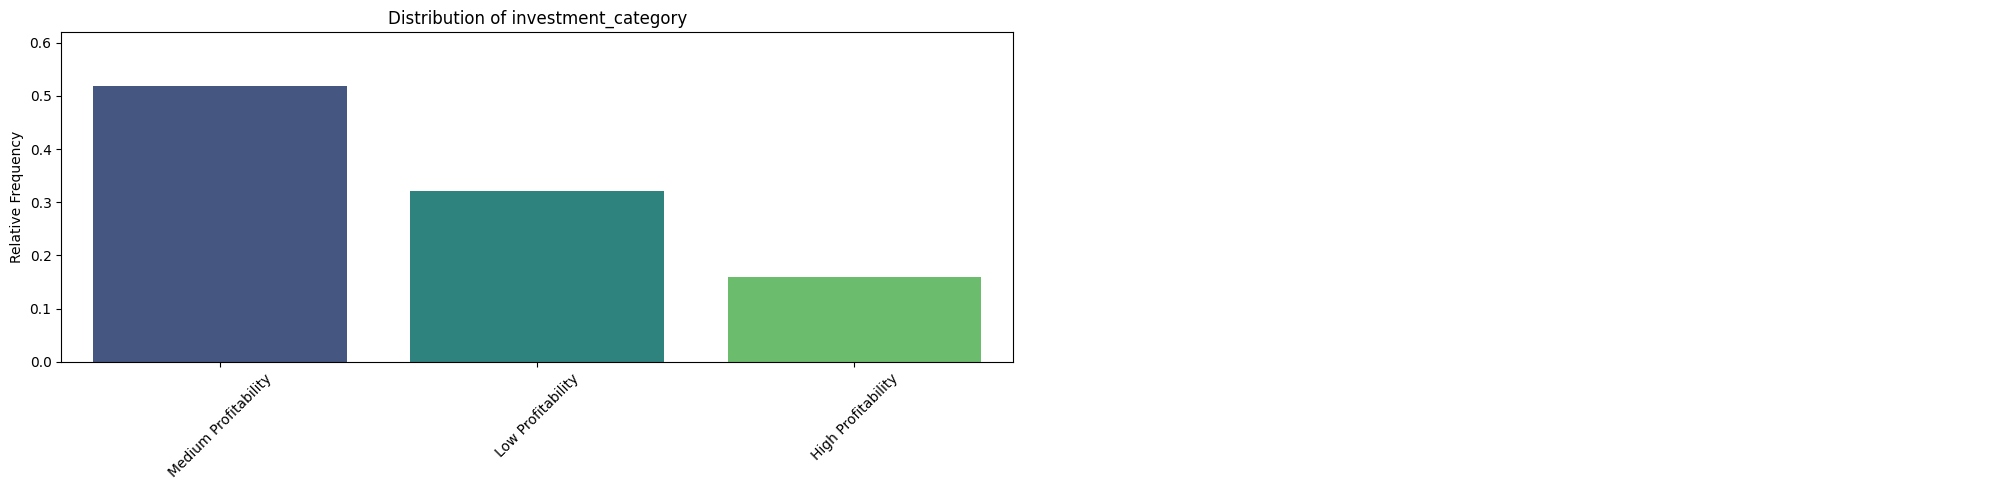

In [19]:
cat_cols = 'investment_category'
dpf.plot_categorical_distribution(housing_us, [cat_cols], relative = True)

*The dataset is a little unbalanced, but not too much, so we will continue with the process working with this data.*

In [20]:
from sklearn.model_selection import train_test_split

# Split into train and test sets
X = housing_us.drop(columns=["property_id", "ROI", "investment_category"])
y = housing_us["investment_category"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the split sizes
X_train.shape, X_test.shape, y_train.value_counts(normalize=True)

((12086, 17),
 (3022, 17),
 investment_category
 Medium Profitability    0.519444
 Low Profitability       0.320536
 High Profitability      0.160020
 Name: proportion, dtype: float64)

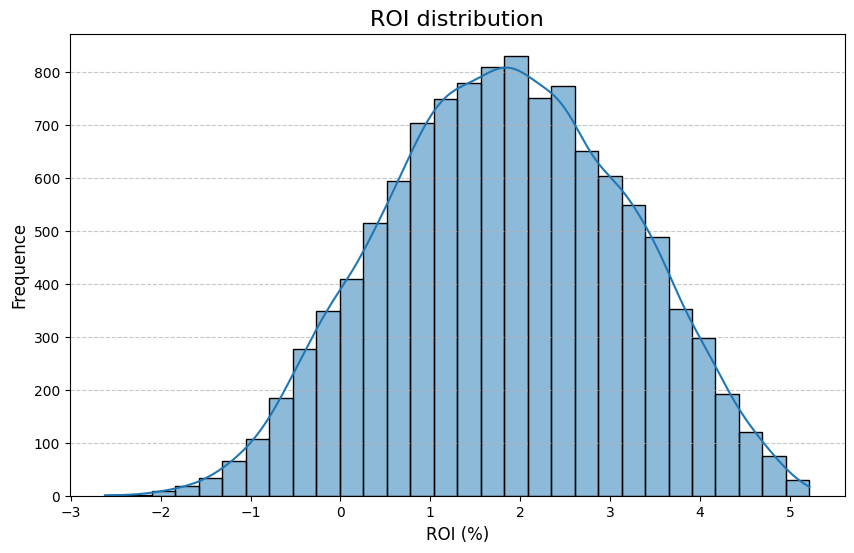

In [21]:
plt.figure(figsize = (10, 6))
sns.histplot(housing_us["ROI"], bins = 30, kde = True)
plt.title("ROI distribution", fontsize = 16)
plt.xlabel("ROI (%)", fontsize = 12)
plt.ylabel("Frequence", fontsize = 12)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.show()